# BIO Project

## For GSE45827
First block is just preprocsessing and attaching the annotation file

In [2]:
# Load required libraries
library(affy)      # For reading CEL files and performing RMA normalization
library(dplyr)     # For data manipulation

# -----------------------------
# 1. Extract the tar file containing the raw CEL files
# -----------------------------
tar_file <- "GSE45827_RAW.tar"
extraction_dir <- "GSE45827_raw"

if (!dir.exists(extraction_dir)) {
  dir.create(extraction_dir)
  untar(tar_file, exdir = extraction_dir)
} else {
  message("Extraction directory already exists. Skipping extraction.")
}

# -----------------------------
# 2. Read and Preprocess the Raw Data
# -----------------------------
# Read in all CEL files from the extracted directory
raw_data <- ReadAffy(celfile.path = extraction_dir)

# Normalize the data using RMA (background correction, normalization, summarization)
eset <- rma(raw_data)
exprs_matrix <- exprs(eset)  # Matrix with probe IDs as row names

# Convert the expression matrix to a data frame and add a column for probe IDs
exprs_df <- as.data.frame(exprs_matrix)
exprs_df$ProbeID <- rownames(exprs_matrix)

# -----------------------------
# 3. Load and Process the Annotation File
# -----------------------------
# Read all lines from the annotation file
all_lines <- readLines("GPL570-55999.txt")

# Remove lines that begin with '#' (the commented header lines)
non_comment_lines <- all_lines[!grepl("^#", all_lines)]

# Combine the remaining lines into a single text block and read it as a table
annotation <- read.delim(text = paste(non_comment_lines, collapse = "\n"),
                         header = TRUE, sep = "\t", stringsAsFactors = FALSE)

# Clean up column names if necessary
colnames(annotation) <- make.names(colnames(annotation))
print(colnames(annotation))
# Expected columns include:
# "ID", "GB_ACC", "SPOT_ID", "Species.Scientific.Name", "Annotation.Date",
# "Sequence.Type", "Sequence.Source", "Target.Description", "Representative.Public.ID",
# "Gene.Title", "Gene.Symbol", "ENTREZ_GENE_ID", "RefSeq.Transcript.ID",
# "Gene.Ontology.Biological.Process", "Gene.Ontology.Cellular.Component",
# "Gene.Ontology.Molecular.Function"

# -----------------------------
# 4. Merge the Annotation with the Expression Data
# -----------------------------
# Merge using the "ID" column from annotation (probe ID) and "ProbeID" from expression data.
exprs_annot <- merge(annotation[, c("ID", "Gene.Symbol")],
                     exprs_df,
                     by.x = "ID",
                     by.y = "ProbeID",
                     all.y = FALSE)

# Remove rows where Gene.Symbol is missing or blank
exprs_annot <- exprs_annot[!is.na(exprs_annot$Gene.Symbol) & exprs_annot$Gene.Symbol != "", ]

# -----------------------------
# 5. Collapse Multiple Probes per Gene by Averaging
# -----------------------------
exprs_gene <- exprs_annot %>%
  group_by(Gene.Symbol) %>%
  summarise(across(where(is.numeric), mean, na.rm = TRUE))

# Convert the data frame into a matrix with gene symbols as row names
exprs_matrix_final <- as.matrix(exprs_gene[, -1])
rownames(exprs_matrix_final) <- exprs_gene$Gene.Symbol

# -----------------------------
# 6. Write the Final Processed Data to a CSV File
# -----------------------------
write.csv(exprs_matrix_final, file = "GSE45827_processed.csv", row.names = TRUE)
cat("Processing complete. The file 'GSE45827_processed.csv' has been created.\n")


Extraction directory already exists. Skipping extraction.

Warning message:
“replacing previous import ‘AnnotationDbi::tail’ by ‘utils::tail’ when loading ‘hgu133plus2cdf’”
Warning message:
“replacing previous import ‘AnnotationDbi::head’ by ‘utils::head’ when loading ‘hgu133plus2cdf’”




Background correcting
Normalizing
Calculating Expression
 [1] "ID"                               "GB_ACC"                          
 [3] "SPOT_ID"                          "Species.Scientific.Name"         
 [5] "Annotation.Date"                  "Sequence.Type"                   
 [7] "Sequence.Source"                  "Target.Description"              
 [9] "Representative.Public.ID"         "Gene.Title"                      
[11] "Gene.Symbol"                      "ENTREZ_GENE_ID"                  
[13] "RefSeq.Transcript.ID"             "Gene.Ontology.Biological.Process"
[15] "Gene.Ontology.Cellular.Component" "Gene.Ontology.Molecular.Function"
Processing complete. The file 'GSE45827_processed.csv' has been created.


In [1]:
import pandas as pd
from collections import Counter, defaultdict

# Read the CSV file into a DataFrame
df = pd.read_csv("/Users/abdullahsaqib/Desktop/GSE45827_processed.csv")


# Print the first few rows to verify the DataFrame loaded correctly
print("DataFrame head:")
print(df.head())

# Get the list of column names from the DataFrame
columns = df.columns.tolist()

# Filter out the columns that start with "GSM1116"
patient_columns = [col for col in columns if col.startswith("GSM1116")]

# Extract the patient ID from each column name (the substring before the first underscore)
patient_ids = [col.split("_")[0] for col in patient_columns]

# Count the occurrences of each patient ID
id_counts = Counter(patient_ids)

# Identify patient IDs that occur more than once (i.e., duplicates)
duplicates = {pid: count for pid, count in id_counts.items() if count > 1}

print("\nDuplicate patient IDs and their counts:")
for pid, count in duplicates.items():
    print(pid, count)

# Group the patient columns by their patient ID
# Create a dictionary mapping each patient ID to the list of corresponding column names
patient_col_dict = defaultdict(list)
for col in patient_columns:
    pid = col.split("_")[0]
    patient_col_dict[pid].append(col)

# For each patient ID, if there are duplicates, take the row-wise mean; otherwise, use the column as is.
aggregated_cols = {}
for pid, cols in patient_col_dict.items():
    if len(cols) > 1:
        aggregated_cols[pid] = df[cols].mean(axis=1)
    else:
        aggregated_cols[pid] = df[cols[0]]

# Create a DataFrame from the aggregated patient columns
aggregated_df = pd.DataFrame(aggregated_cols)

# Get non-patient columns (e.g. "ID", "Gene.Symbol", etc.)
non_patient_columns = [col for col in df.columns if not col.startswith("GSM1116")]

# Combine the non-patient columns with the aggregated patient columns.
# We reset the index to ensure proper concatenation.
final_df = pd.concat([df[non_patient_columns].reset_index(drop=True), 
                      aggregated_df.reset_index(drop=True)], axis=1)

# Save the final DataFrame to a new CSV file
final_df.to_csv("GSE45827_bhaiplease.csv", index=False)

print("\nAggregated DataFrame saved as 'GSE45827_GeneMapped_aggregated.csv'.")

DataFrame head:
  Unnamed: 0  GSM1116084_BC04_ARN0001_s1h1s1_U133p2.CEL.gz  \
0       A1BG                                      7.123746   
1   A1BG-AS1                                      4.790420   
2       A1CF                                      3.996734   
3        A2M                                      7.635882   
4    A2M-AS1                                      5.797665   

   GSM1116085_BC04_ARN0002_s1h1s1_U133p2.CEL.gz  \
0                                      6.258131   
1                                      4.405871   
2                                      3.695598   
3                                      7.314915   
4                                      5.617049   

   GSM1116085_BC16_ARN0062_s1h1s1_U133p2.CEL.gz  \
0                                      6.234535   
1                                      4.116098   
2                                      3.903467   
3                                      7.445292   
4                                      5.264122  

## DEGs of GSE45827
This block just reads the processed data and does all the functionality to output the DEGs

In [1]:
# Load required package
library(limma)

# -----------------------------
# 1. Load Preprocessed Expression Data
# -----------------------------
# Read the CSV file (ensure that gene symbols are in the first column as row names)
exprs_data <- read.csv("/Users/abdullahsaqib/Desktop/GSE45827_bhaiplease.csv", row.names = 1)

# Check the dimensions of the data
dim(exprs_data)

# -----------------------------
# 2. Define Group Labels for Samples
# -----------------------------
# The sample ordering is as follows:
# - First 85 samples: cancer
# - Next 11 samples: normal
# - Final 59 samples: cancer
group <- factor(c(rep("cancer", 85), rep("normal", 11), rep("cancer", 59)))

# Verify the length matches the number of samples (columns) in the expression data
stopifnot(length(group) == ncol(exprs_data))

# -----------------------------
# 3. Create Design Matrix and Define Contrast
# -----------------------------
# Create a design matrix without an intercept
design <- model.matrix(~ 0 + group)
colnames(design) <- levels(group)

# Define the contrast: cancer vs. normal
contrast.matrix <- makeContrasts(cancer - normal, levels = design)

# -----------------------------
# 4. Fit the Linear Model with limma
# -----------------------------
fit <- lmFit(exprs_data, design)
fit2 <- contrasts.fit(fit, contrast.matrix)
fit2 <- eBayes(fit2)

# -----------------------------
# 5. Extract Differentially Expressed Genes (DEGs)
# -----------------------------
# Filter DEGs with an absolute log-fold change >= 2 and adjusted p-value < 0.05
deg <- topTable(fit2, adjust.method = "BH", number = Inf, p.value = 0.05, lfc = 2)

# Display the top DEGs
head(deg)

# -----------------------------
# 6. Write DEG Results to a CSV File
# -----------------------------
write.csv(deg, file = "DEG_GSE45827.csv", row.names = TRUE)
cat("DEG analysis complete. The file 'DEG_GSE45827.csv' has been created.\n")


[1] 23520   155

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ANKRD20A1 /// ANKRD20A2 /// ANKRD20A3 /// ANKRD20A4,-3.507432,3.657878,-24.27284,1.030088e-54,1.211383e-50,113.82674
SCARA5,-2.739336,4.654851,-22.29725,2.937148e-50,1.727043e-46,103.72949
AC092192.1,-2.886677,3.570320,-22.11024,7.954748e-50,3.741913e-46,102.74756
CA4,-2.175235,4.385534,-21.43577,2.999841e-48,1.175938e-44,99.16839
CCDC144CP,-2.305601,3.359473,-21.34853,4.817667e-48,1.618736e-44,98.70110
FRG1B,-2.843819,5.561873,-20.70107,1.670211e-46,4.364818e-43,95.20214


DEG analysis complete. The file 'DEG_GSE45827.csv' has been created.


In [5]:
length(group)



[1] 155

In [2]:
getwd()

[1] "/Users/abdullahsaqib"

# Merged Dataset

## Attaching Annotation File to the Datasets
This is after the RMA preprocessing and annotation attachment

In [1]:
#library(GEOquery)
library(affy)
library(limma)
library(AnnotationDbi)
library(hgu133plus2.db)
#library(tidyverse)
library(sva)
library(ggbiplot)

# 1) Manually downloaded the files into my working directory

untar("GSE10810_RAW.tar", exdir = "GSE10810_raw")
untar("GSE42568_RAW.tar", exdir = "GSE42568_raw")


# --------------------------------------------
# (Optional) Inspect what got extracted
# --------------------------------------------
list.files("GSE10810_raw")
list.files("GSE42568_raw")

# 2) Point to the .CEL.gz files
cel_files_10810 <- list.celfiles("GSE10810_raw", pattern = ".CEL.gz", full.names = TRUE)
cel_files_42568 <- list.celfiles("GSE42568_raw", pattern = ".CEL.gz", full.names = TRUE)

# 3) Read with ReadAffy and do RMA
gse10810_affy <- ReadAffy(filenames = cel_files_10810)
gse10810_rma  <- rma(gse10810_affy)
gse10810_expr <- exprs(gse10810_rma)

gse42568_affy <- ReadAffy(filenames = cel_files_42568)
gse42568_rma  <- rma(gse42568_affy)
gse42568_expr <- exprs(gse42568_rma)

# Confirm dimensions of the resulting expression matrices
dim(gse10810_expr)
dim(gse42568_expr)


#_________________________________________________________________________________________________________________________

# Read the annotation file, skipping lines starting with '#'
annotation <- read.delim(
  "GPL570-55999.txt",
  comment.char = "#",
  header = TRUE,
  stringsAsFactors = FALSE
)

# Check the column names
colnames(annotation)
# [1] "ID"               "GB_ACC"            "SPOT_ID"  ...
# [5] "Species.Scientific.Name"  "Annotation.Date" ...
# ...
# [11] "Gene.Symbol" 


library(dplyr)
library(tibble)

annotation_sub <- annotation %>%
  dplyr::select(ID, Gene.Symbol) %>%
  # Remove any rows with missing or empty gene symbols
  filter(!is.na(Gene.Symbol) & Gene.Symbol != "")

#_________________________________________________________________________________________________________________________
# Convert the GSE10810 expression matrix into a data frame (with probe IDs in a column "ID")
gse10810_df <- as.data.frame(gse10810_expr) %>%
  rownames_to_column("ID")

# Merge with annotation (this keeps only probes present in both)
merged_10810 <- gse10810_df %>%
  inner_join(annotation_sub, by = "ID") %>%
  # Filter out rows that might have empty or NA gene symbols (if needed)
  filter(!is.na(Gene.Symbol) & Gene.Symbol != "")

# Now average multiple probes mapping to the same gene
gse10810_gene <- merged_10810 %>%
  group_by(Gene.Symbol) %>%
  summarise(across(where(is.numeric), mean, na.rm = TRUE)) %>%
  ungroup() %>%
  column_to_rownames("Gene.Symbol") %>%
  as.matrix()

# 'gse10810_gene' is now a gene-level matrix (rows = gene symbols, columns = samples).
dim(gse10810_gene)

#_________________________________________________________________________________________________________________________
gse42568_df <- as.data.frame(gse42568_expr) %>%
  rownames_to_column("ID")

# Merge with annotation (only keep probes present in both the expression data and annotation)
merged_42568 <- gse42568_df %>%
  inner_join(annotation_sub, by = "ID") %>%
  # Filter out rows that might have empty or NA gene symbols
  filter(!is.na(Gene.Symbol) & Gene.Symbol != "")

# Average multiple probes mapping to the same gene symbol
gse42568_gene <- merged_42568 %>%
  group_by(Gene.Symbol) %>%
  summarise(across(where(is.numeric), mean, na.rm = TRUE)) %>%
  ungroup() %>%
  column_to_rownames("Gene.Symbol") %>%
  as.matrix()

# Now 'gse42568_gene' is a gene-level expression matrix (rows = Gene Symbols, columns = samples).
dim(gse42568_gene)
#_________________________________________________________________________________________________________________________

write.csv(gse10810_gene, "GSE10810_GeneLevel.csv")
write.csv(gse42568_gene, "GSE42568_GeneLevel.csv")



Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, saveRDS, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.



Attaching package: ‘limma’


The following object is masked from ‘package:BiocGenerics’:

    plotMA


Loading required package: stats4

Load

[1] "GSM272923.CEL.gz" "GSM272924.CEL.gz" "GSM272925.CEL.gz" "GSM272926.CEL.gz"
 [5] "GSM272927.CEL.gz" "GSM272928.CEL.gz" "GSM272929.CEL.gz" "GSM272930.CEL.gz"
 [9] "GSM272931.CEL.gz" "GSM272932.CEL.gz" "GSM272933.CEL.gz" "GSM272934.CEL.gz"
[13] "GSM272935.CEL.gz" "GSM272936.CEL.gz" "GSM272937.CEL.gz" "GSM272938.CEL.gz"
[17] "GSM272939.CEL.gz" "GSM272940.CEL.gz" "GSM272941.CEL.gz" "GSM272942.CEL.gz"
[21] "GSM272943.CEL.gz" "GSM272944.CEL.gz" "GSM272945.CEL.gz" "GSM272946.CEL.gz"
[25] "GSM272947.CEL.gz" "GSM272948.CEL.gz" "GSM272949.CEL.gz" "GSM272950.CEL.gz"
[29] "GSM272951.CEL.gz" "GSM272952.CEL.gz" "GSM272953.CEL.gz" "GSM272954.CEL.gz"
[33] "GSM272955.CEL.gz" "GSM272956.CEL.gz" "GSM272957.CEL.gz" "GSM272958.CEL.gz"
[37] "GSM272959.CEL.gz" "GSM272960.CEL.gz" "GSM272961.CEL.gz" "GSM272962.CEL.gz"
[41] "GSM272963.CEL.gz" "GSM272964.CEL.gz" "GSM272965.CEL.gz" "GSM272966.CEL.gz"
[45] "GSM272967.CEL.gz" "GSM272968.CEL.gz" "GSM272969.CEL.gz" "GSM272970.CEL.gz"
[49] "GSM272971.CEL.gz" "GSM272972.CEL.gz" "GSM272973.CEL.gz" "GSM272974.CEL.gz"
[53] "GSM272975.CEL.gz" "GSM272976.CEL.gz" "GSM272977.CEL.gz" "GSM272978.CEL.gz"
[57] "GSM272979.CEL.gz" "GSM272980.CEL.gz"

[1] "GSM1045191_N1_15_12_04.CEL.gz"   "GSM1045192_N4_14_12_04.CEL.gz"  
  [3] "GSM1045193_N5_15_12_04.CEL.gz"   "GSM1045194_N6_14_12_04.CEL.gz"  
  [5] "GSM1045195_P1_15_12_04.CEL.gz"   "GSM1045196_P10_26_1_05.CEL.gz"  
  [7] "GSM1045197_P11_25_1_05.CEL.gz"   "GSM1045198_P12_25_1_05.CEL.gz"  
  [9] "GSM1045199_P13_25_1_05.CEL.gz"   "GSM1045200_P14_25_1_05.CEL.gz"  
 [11] "GSM1045201_P18_25_1_05.CEL.gz"   "GSM1045202_P21_25_1_05.CEL.gz"  
 [13] "GSM1045203_P3_22_12_04.CEL.gz"   "GSM1045204_P4_14_12_04.CEL.gz"  
 [15] "GSM1045205_P5_21_12_04.CEL.gz"   "GSM1045206_P8_25_1_05.CEL.gz"   
 [17] "GSM1045207_P9_25_1_05.CEL.gz"    "GSM1045208_S1_21_12_04.CEL.gz"  
 [19] "GSM1045209_S10_22_12_04.CEL.gz"  "GSM1045210_S11_14_12_04.CEL.gz" 
 [21] "GSM1045211_S14_21_12_04.CEL.gz"  "GSM1045212_S15_15_12_04.CEL.gz" 
 [23] "GSM1045213_S16_20_12_04.CEL.gz"  "GSM1045214_S18_22_12_04.CEL.gz" 
 [25] "GSM1045215_S2_15_12_04.CEL.gz"   "GSM1045216_S20_14_12_04.CEL.gz" 
 [27] "GSM1045217_S22_9_12_04.CEL.gz"   "GSM1045218_S25_10_12_04.CEL.gz" 
 [29] "GSM1045219_S26_10_12_04.CEL.gz"  "GSM1045220_S28_7_12_04.CEL.gz"  
 [31] "GSM1045221_S29_10_12_04.CEL.gz"  "GSM1045222_S3_20_12_04.CEL.gz"  
 [33] "GSM1045223_S30_14_12_04.CEL.gz"  "GSM1045224_S31_3_12_04.CEL.gz"  
 [35] "GSM1045225_S32_3_12_04.CEL.gz"   "GSM1045226_S33_3_12_04.CEL.gz"  
 [37] "GSM1045227_S35_8_12_04.CEL.gz"   "GSM1045228_S36_20_12_04.CEL.gz" 
 [39] "GSM1045229_S37_8_12_04.CEL.gz"   "GSM1045230_S38_10_12_04.CEL.gz" 
 [41] "GSM1045231_S5_15_12_04.CEL.gz"   "GSM1045232_S6_20_12_04.CEL.gz"  
 [43] "GSM1045233_S7_14_12_04.CEL.gz"   "GSM1045234_T1_14_12_04.CEL.gz"  
 [45] "GSM1045235_T10_8_12_04.CEL.gz"   "GSM1045236_T101A_9_12_04.CEL.gz"
 [47] "GSM1045237_T103_9_12_04.CEL.gz"  "GSM1045238_T104_9_12_04.CEL.gz" 
 [49] "GSM1045239_T105B.CEL.gz"         "GSM1045240_T106_21_12_04.CEL.gz"
 [51] "GSM1045241_T107_7_12_04.CEL.gz"  "GSM1045242_T108_21_12_04.CEL.gz"
 [53] "GSM1045243_T109_21_12_04.CEL.gz" "GSM1045244_T11_21_12_04.CEL.gz" 
 [55] "GSM1045245_T111_14_12_04.CEL.gz" "GSM1045246_T112_3_12_04.CEL.gz" 
 [57] "GSM1045247_T113_22_12_04.CEL.gz" "GSM1045248_T114_7_12_04.CEL.gz" 
 [59] "GSM1045249_T115_15_12_04.CEL.gz" "GSM1045250_T119_8_12_04.CEL.gz" 
 [61] "GSM1045251_T12_22_12_04.CEL.gz"  "GSM1045252_T120_10_12_04.CEL.gz"
 [63] "GSM1045253_T122_9_12_04.CEL.gz"  "GSM1045254_T123_14_12_04.CEL.gz"
 [65] "GSM1045255_T124_25_1_05.CEL.gz"  "GSM1045256_T125_21_12_04.CEL.gz"
 [67] "GSM1045257_T127_8_12_04.CEL.gz"  "GSM1045258_T128_22_12_04.CEL.gz"
 [69] "GSM1045259_T129_20_12_04.CEL.gz" "GSM1045260_T13_9_12_04.CEL.gz"  
 [71] "GSM1045261_T130_8_12_04.CEL.gz"  "GSM1045262_T131_22_12_04.CEL.gz"
 [73] "GSM1045263_T132.CEL.gz"          "GSM1045264_T134_7_12_04.CEL.gz" 
 [75] "GSM1045265_T14_21_12_04.CEL.gz"  "GSM1045266_T18_22_12_04.CEL.gz" 
 [77] "GSM1045267_T2_7_12_04.CEL.gz"    "GSM1045268_T20_20_12_04.CEL.gz" 
 [79] "GSM1045269_T21_21_12_04.CEL.gz"  "GSM1045270_T22_10_12_04.CEL.gz" 
 [81] "GSM1045271_T23_9_12_04.CEL.gz"   "GSM1045272_T24_10_12_04.CEL.gz" 
 [83] "GSM1045273_T29_14_12_04.CEL.gz"  "GSM1045274_T30_8_12_04.CEL.gz"  
 [85] "GSM1045275_T32_3_12_04.CEL.gz"   "GSM1045276_T33_3_12_04.CEL.gz"  
 [87] "GSM1045277_T34_20_12_04.CEL.gz"  "GSM1045278_T35_3_12_04.CEL.gz"  
 [89] "GSM1045279_T36_15_12_04.CEL.gz"  "GSM1045280_T38_25_1_05.CEL.gz"  
 [91] "GSM1045281_T39_14_12_04.CEL.gz"  "GSM1045282_T40_9_12_04.CEL.gz"  
 [93] "GSM1045283_T41_20_12_04.CEL.gz"  "GSM1045284_T43_9_12_04.CEL.gz"  
 [95] "GSM1045285_T45_7_12_04.CEL.gz"   "GSM1045286_T47_20_12_04.CEL.gz" 
 [97] "GSM1045287_T49_10_12_04.CEL.gz"  "GSM1045288_T5_10_12_04.CEL.gz"  
 [99] "GSM1045289_T51_7_12_04.CEL.gz"   "GSM1045290_T52_15_12_04.CEL.gz" 
[101] "GSM1045291_T56_15_12_04.CEL.gz"  "GSM1045292_T62_26_1_05.CEL.gz"  
[103] "GSM1045293_T63_22_12_04.CEL.gz"  "GSM1045294_T65_20_12_04.CEL.gz" 
[105] "GSM1045295_T66_25_1_05.CEL.gz"   "GSM1045296_T67_7_12_04.CEL.gz"  
[107] "GSM1045297_T69_15_12_04.CEL.gz"  "GSM1045298_T70_21_12_04.CEL.gz" 
[109] 

Warning message:
“replacing previous import ‘AnnotationDbi::tail’ by ‘utils::tail’ when loading ‘hgu133plus2cdf’”
Warning message:
“replacing previous import ‘AnnotationDbi::head’ by ‘utils::head’ when loading ‘hgu133plus2cdf’”




Background correcting
Normalizing
Calculating Expression
Background correcting
Normalizing
Calculating Expression


[1] 54675    58

[1] 54675   121

[1] "ID"                               "GB_ACC"                          
 [3] "SPOT_ID"                          "Species.Scientific.Name"         
 [5] "Annotation.Date"                  "Sequence.Type"                   
 [7] "Sequence.Source"                  "Target.Description"              
 [9] "Representative.Public.ID"         "Gene.Title"                      
[11] "Gene.Symbol"                      "ENTREZ_GENE_ID"                  
[13] "RefSeq.Transcript.ID"             "Gene.Ontology.Biological.Process"
[15] "Gene.Ontology.Cellular.Component" "Gene.Ontology.Molecular.Function"


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from ‘package:nlme’:

    collapse


The following object is masked from ‘package:AnnotationDbi’:

    select


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“There was 1 warning in `summarise()`.
ℹ In argument: `across(where(is.numeric), mean, na.rm = TR

[1] 23520    58

[1] 23520   121

In [10]:
library(devtools)
devtools::install_github("vqv/ggbiplot")




Loading required package: usethis




plyr (NA -> 1.8.9) [CRAN]


Installing 1 packages: plyr




The downloaded binary packages are in
	/var/folders/r4/8dcrm4qn38s6bjnvd17cg1t00000gn/T//Rtmp1SPjRY/downloaded_packages
── R CMD build ─────────────────────────────────────────────────────────────────
✔  checking for file ‘/private/var/folders/r4/8dcrm4qn38s6bjnvd17cg1t00000gn/T/Rtmp1SPjRY/remotes19746e2c0134/vqv-ggbiplot-f7ea76d/DESCRIPTION’ (404ms)
─  preparing ‘ggbiplot’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts (350ms)
─  checking for empty or unneeded directories
─  looking to see if a ‘data/datalist’ file should be added
─  building ‘ggbiplot_0.55.tar.gz’
   


## This is after the preprocessing and annotation file attachment, we will now do combat and DEG

In [2]:
###############################################################################
# 1) Install & Load Required Packages
###############################################################################
library(dplyr)
library(tibble)
library(limma)
library(sva)
library(ggbiplot)
library(ggplot2)

###############################################################################
# 2) Read Gene-Level CSVs (GSE10810 & GSE42568) & Convert to Matrix
###############################################################################
# Each CSV has rows = genes and columns = samples, with gene in the FIRST column.
# row.names=1 ensures that first column becomes row names (genes).

gse10810_gene <- read.csv("/Users/abdullahsaqib/Desktop/GSE10810_GeneLevel.csv",
                          header = TRUE,
                          row.names = 1,
                          stringsAsFactors = FALSE)
gse42568_gene <- read.csv("/Users/abdullahsaqib/Desktop/GSE42568_GeneLevel.csv",
                          header = TRUE,
                          row.names = 1,
                          stringsAsFactors = FALSE)

gse10810_gene <- as.matrix(gse10810_gene)
gse42568_gene <- as.matrix(gse42568_gene)

# Check dimensions
dim(gse10810_gene)  # e.g. ~23,520 x 58 (pre-filter)
dim(gse42568_gene)  # e.g. ~23,520 x 121 (pre-filter)

###############################################################################
# 3) Filter Genes by Expression:
#    a) Keep genes with mean(log2 expr) >= 3
#    b) Keep genes with expression >= 5 in at least 10% of samples   you can change both of these according to your liking
###############################################################################

# For GSE10810
row_means_10810 <- rowMeans(gse10810_gene)
keep_mean_10810 <- (row_means_10810 >= 3)
gse10810_filt   <- gse10810_gene[keep_mean_10810, ]

frac_cutoff <- 0.10
n_samples_10810 <- ncol(gse10810_filt)
expressed_count_10810 <- rowSums(gse10810_filt >= 5)
keep_expr_10810 <- (expressed_count_10810 / n_samples_10810) >= frac_cutoff
gse10810_filt <- gse10810_filt[keep_expr_10810, ]

cat("GSE10810 final filter dimension:", dim(gse10810_filt), "\n")

# For GSE42568
row_means_42568 <- rowMeans(gse42568_gene)
keep_mean_42568 <- (row_means_42568 >= 3)
gse42568_filt   <- gse42568_gene[keep_mean_42568, ]

n_samples_42568 <- ncol(gse42568_filt)
expressed_count_42568 <- rowSums(gse42568_filt >= 5)
keep_expr_42568 <- (expressed_count_42568 / n_samples_42568) >= frac_cutoff
gse42568_filt <- gse42568_filt[keep_expr_42568, ]

cat("GSE42568 final filter dimension:", dim(gse42568_filt), "\n")

###############################################################################
# 4) Intersect Genes, then cbind
###############################################################################
common_genes <- intersect(rownames(gse10810_filt), rownames(gse42568_filt))
gse10810_filt <- gse10810_filt[common_genes, ]
gse42568_filt <- gse42568_filt[common_genes, ]

merged_dataset <- cbind(gse10810_filt, gse42568_filt)
dim(merged_dataset)
# e.g. maybe (12,000, 179) depending on your data & filters
write.csv(merged_dataset, "Merged_Dataset_beforecombatbruh.csv",
          row.names = TRUE)

###############################################################################
# 5) (Variance filtering step removed as recommended)
###############################################################################
# We do NOT perform additional variance-based pruning so as to preserve borderline genes.
#target_n <- 10629
#gene_variances <- apply(merged_dataset, 1, var)
#sorted_indices <- order(gene_variances, decreasing = TRUE)
#top_indices <- sorted_indices[1:target_n]
#merged_dataset <- merged_dataset[top_indices, ]

###############################################################################
# 6) Batch Effect Correction via ComBat
###############################################################################
batch <- c(
  rep("GSE10810", 58),
  rep("GSE42568", 121)
)
batch <- factor(batch)

# Create a design matrix to preserve biological differences
group_vector <- c(
  rep("Normal", 27),
  rep("Cancer", 31),
  rep("Normal", 17),
  rep("Cancer", 104)
)
cat("Check group_vector length:", length(group_vector), "\n")
cat("Check merged_dataset columns:", ncol(merged_dataset), "\n")
group_factor <- factor(group_vector, levels = c("Normal", "Cancer"))
mod <- model.matrix(~ group_factor)  # design matrix with biological variable

#merged_dataset <- log2(merged_dataset + 1)

# Set ref.batch to "GSE10810" to preserve the fold changes relative to that batch
combat_corrected <- ComBat(
  dat = merged_dataset,
  batch = batch,
  mod = mod,                # include design matrix to preserve biological differences
  par.prior = TRUE,
  prior.plots = FALSE,
  ref.batch = "GSE10810",  # use GSE10810 as the reference batch
  mean.only = TRUE   
)
dim(combat_corrected)

###############################################################################
# 7) (Optional) PCA Before & After ComBat (Visualization)
###############################################################################
# pca_before <- prcomp(t(merged_dataset), center = TRUE, scale. = TRUE)
# ggbiplot(pca_before, groups = batch, ellipse = TRUE) +
#   theme_minimal() +
#   labs(title = "PCA Before ComBat") +
#   theme(legend.position = "bottom")
#
# pca_after <- prcomp(t(combat_corrected), center = TRUE, scale. = TRUE)
# ggbiplot(pca_after, groups = batch, ellipse = TRUE) +
#   theme_minimal() +
#   labs(title = "PCA After ComBat") +
#   theme(legend.position = "bottom")
###############################################################################
# 8) Save Final Merged Dataset
###############################################################################
merged_final <- combat_corrected
write.csv(merged_final, "Merged_Dataset_aftercombat_noVarianceFilter.csv",
          row.names = TRUE)

###############################################################################
# 9) Define Sample Groups & limma DE Analysis
###############################################################################
# Final arrangement: 27 Normal, 31 Cancer, 17 Normal, 104 Cancer = total 179
group_vector <- c(
  rep("Normal", 27),
  rep("Cancer", 31),
  rep("Normal", 17),
  rep("Cancer", 104)
)
cat("Check group_vector length:", length(group_vector), "\n")
cat("Check merged_final columns:", ncol(merged_final), "\n")

group_factor <- factor(group_vector, levels = c("Normal", "Cancer"))
design <- model.matrix(~ 0 + group_factor)
colnames(design) <- c("Normal", "Cancer")

fit <- lmFit(merged_final, design)
contrast.matrix <- makeContrasts(
  CancerMinusNormal = Cancer - Normal,
  levels = design
)
fit2 <- contrasts.fit(fit, contrast.matrix)
fit2 <- eBayes(fit2)

res_table <- topTable(fit2, adjust="fdr", number=Inf)
head(res_table)

# For your DE criteria: |logFC| > 2 & P.Value < 0.05
deg_subset <- subset(res_table, abs(logFC) > 2 & P.Value < 0.05)
cat("DEGs with |logFC| > 2 & p < 0.05:", nrow(deg_subset), "\n")

# Write the subset that meets your logFC/p-value threshold
write.csv(deg_subset, "Merged_DEGs.csv", row.names = TRUE)

# Check and output the logFC and p-value for the gene "DTL"
if("DTL" %in% rownames(res_table)) {
  dtl_values <- res_table["DTL", c("logFC", "P.Value")]
  dtl_logfc <- as.numeric(dtl_values["logFC"])
  dtl_pvalue <- as.numeric(dtl_values["P.Value"])
  cat("Gene DTL: logFC =", dtl_logfc, "and P.Value =", dtl_pvalue, "\n")
} else {
  cat("Gene DTL not found in the DE results.\n")
}

# Optional: Further subset by FDR if desired
# deg_subset_FDR <- subset(deg_subset, adj.P.Val < 0.05)
# cat("DEGs with |logFC| > 2 & FDR < 0.05:", nrow(deg_subset_FDR), "\n")


[1] 23520    58

[1] 23520   121

GSE10810 final filter dimension: 16039 58 
GSE42568 final filter dimension: 13137 121 


[1] 12981   179

Check group_vector length: 179 
Check merged_dataset columns: 179 


Using the 'mean only' version of ComBat

Using batch =GSE10810as a reference batch (this batch won't change)

Found2batches

Adjusting for1covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




[1] 12981   179

Check group_vector length: 179 
Check merged_final columns: 179 


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TMEM132C,-2.710271,6.908270,-27.29061,5.626586e-66,7.303871e-62,139.7882
LOC284825,-3.212901,5.150671,-26.57687,2.608452e-64,1.693016e-60,135.9870
SDPR,-3.500091,6.145074,-25.21750,4.615726e-61,1.997225e-57,128.5721
CA4,-2.443704,5.921319,-24.86857,3.265224e-60,1.059647e-56,126.6312
ADH1C,-3.349062,5.233446,-24.81986,4.295815e-60,1.115279e-56,126.3591
PGM5-AS1,-2.220540,5.855229,-24.55485,1.920801e-59,4.155654e-56,124.8730


DEGs with |logFC| > 2 & p < 0.05: 289 
Gene DTL: logFC = 2.351487 and P.Value = 2.233414e-39 


## This is to check the DEGs, name the input file according to your output file

In [1]:
import pandas as pd

# List of genes of interest
genes_of_interest = [
    "ACACB", "ADAMTS5", "ADH1B", "ADIPOQ", "CD36", "CDC20", "CFD", "CIDEA", "CIDEC",
    "COL10A1", "DTL", "EDNRB", "EZH2", "GPC3", "GPD1", "LEP", "LPL", "MMP1", "PRC1", "RARRES2",
    "RBP4", "S100B", "S100P", "SFRP1", "SPP1", "TOP2A", "ZBTB16", "ZWINT"
]

# genes_of_interest = [
#     "ACACB", "ACADL", "ACSL1", "ACVR1C", "ADAMTS5", "ADH1B", "ADH1C", "ADIPOQ", "ADIRF", "ADM", "ADRA2A", "AGR2", "AGR3", "AKAP12", "AKR1C1 /// AKR1C2 /// LOC101930400", "AKR1C2 /// LOC101930400", "AKR1C3", "ALDH1A1", "ALDH2", "ANKRD30A", "ANXA1", "AOC3", "APOD", "AQP7 /// LOC100509620 /// LOC101930168", "AQPEP", "ASPA", "ATP1A2", "BLOC1S1-RDH5 /// RDH5", "C14orf180", "C15orf48", "C2orf40", "CALB2", "CAV1", "CAV2", "CCDC3", "CCDC69", "CD24", "CD36", "CDC20", "CDO1", "CEACAM6", "CEBPA", "CES1 /// LOC100653057", "CFD", "CFH", "CHRDL1", "CIDEA", "CIDEC", "CKS2", "CLEC3B /// EXOSC7", "CLMP", "COL10A1", "COL11A1", "COMP", "COPG2IT1", "COX7A1", "CRYAB", "DDR2", "DEFB132", "DGAT2", "DPT", "DSP", "EBF1", "ENPP2", "EPCAM", "ESRP1", "EZH2", "FABP4", "FAM89A /// MIR1182", "FGFBP2", "FHL1", "FIGF /// PIR-FIGF", "FMO2", "FOS", "FOSB", "FOXA1", "G0S2", "GALNT6", "GATA3", "GHR", "GINS1", "GJB2", "GLYAT", "GNAI1", "GPAM", "GPD1", "GPR146", "GPR34", "GPX3", "GYG2", "HBA1 /// HBA2", "HBB", "HCAR3", "HEPACAM /// HEPN1", "HSD11B1", "IGFBP6", "ITGA7", "ITIH5", "KLB", "KRT18", "KRT8", "LEP", "LGALS12", "LINC00341 /// SYNE3", "LINC01279", "LOC101926960", "LOC101930114", "LOC284825", "LPL", "LRRN3", "LRRN4CL", "LYVE1", "MAMDC2", "MAOA", "MARC1", "MCAM", "MEST", "MFAP5", "MGLL", "MICU3", "MME", "MMP1", "MRAP", "MRC1", "MT1M", "MYZAP", "NRN1", "NUSAP1", "OGN", "P2RY14", "PAFAH1B3", "PALMD", "PCK1", "PCOLCE2", "PDE3B", "PLA2G4A", "PLIN1", "PLIN4", "PPARG", "PPP1R14A", "PPP1R1A", "PRC1", "PRKAR2B", "PRSS8", "PYGL", "RAB25", "RARRES2", "RBP4", "RBP7", "RRM2", "RSPO3", "S100P", "SAA1 /// SAA2", "SAA1 /// SAA2 /// SAA2-SAA4", "SCARA5", "SDC1", "SDPR", "SEMA3G", "SGCG", "SLC16A7", "SLC19A3", "SPINT2", "SPX", "SRPX", "TGFBR3", "THRSP", "TIMP4", "TMEM100", "TMEM132C", "TMEM170B", "TNMD", "TUSC5", "UHRF1", "VGLL3", "VLDLR", "WASF3", "WISP2", "ZBTB16", "ZG16B", "ZWINT"
# ]

# File name for the DEG results
filename = "/Users/abdullahsaqib/Desktop/Merged_DEGs.csv"

# Read the CSV file, using the first column as the row index (gene names)
df = pd.read_csv(filename, header=0, index_col=0)

# Get the set of genes in the file (from the index)
genes_in_file = set(df.index)

# Determine which genes from our list are present and which are missing
found_genes = sorted(genes_in_file.intersection(genes_of_interest))
missing_genes = sorted(set(genes_of_interest) - genes_in_file)

print("File:", filename)
print("Number of genes found:", len(found_genes))
print("Genes found:", found_genes)
print("Genes missing:", missing_genes)

File: /Users/abdullahsaqib/Desktop/Merged_DEGs.csv
Number of genes found: 24
Genes found: ['ACACB', 'ADAMTS5', 'ADH1B', 'ADIPOQ', 'CD36', 'CDC20', 'CFD', 'CIDEA', 'CIDEC', 'COL10A1', 'DTL', 'EDNRB', 'EZH2', 'GPD1', 'LEP', 'LPL', 'MMP1', 'PRC1', 'RARRES2', 'RBP4', 'S100P', 'TOP2A', 'ZBTB16', 'ZWINT']
Genes missing: ['GPC3', 'S100B', 'SFRP1', 'SPP1']


Number of unique genes in File 1: 365 
Number of unique genes in File 2: 173 
Number of genes in common: 25 

Common Genes:
 [1] "LEP"     "GPD1"    "CIDEC"   "ACACB"   "RBP4"    "CFD"     "ADIPOQ" 
 [8] "CIDEA"   "CD36"    "ZWINT"   "ADH1B"   "EZH2"    "PRC1"    "EDNRB"  
[15] "ZBTB16"  "LPL"     "DTL"     "TOP2A"   "ADAMTS5" "COL10A1" "CDC20"  
[22] "S100P"   "AKR1C3"  "RARRES2" "MMP1"   


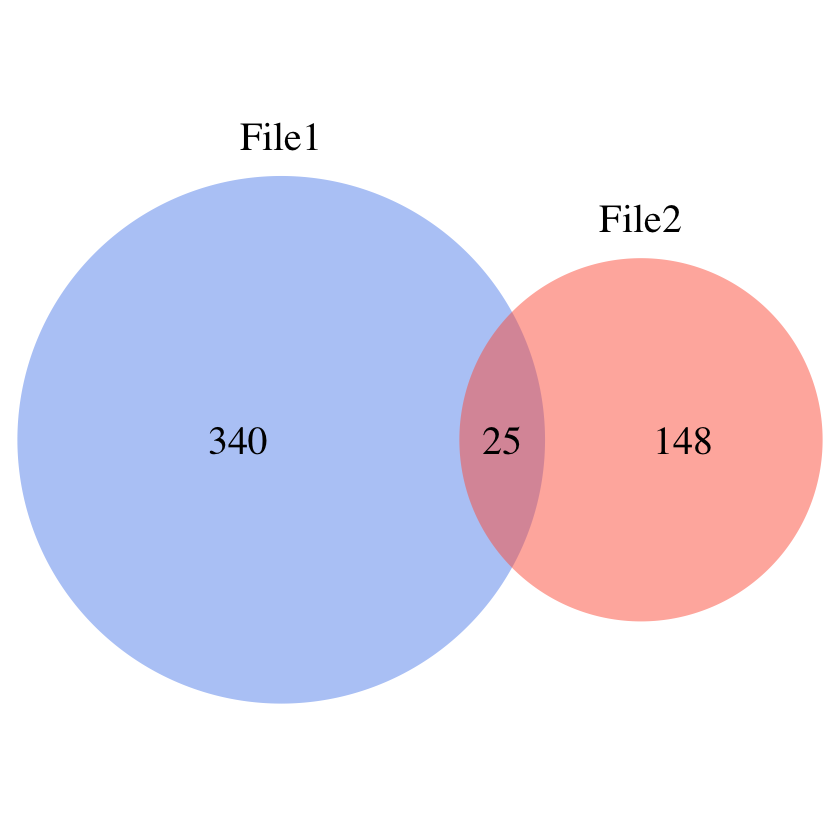

In [9]:
########################################################
# 1. Install/Load Required Package
########################################################
# If you haven't installed VennDiagram yet, uncomment:
# install.packages("VennDiagram")
library(VennDiagram)

########################################################
# 2. Read Gene Lists from CSV Files
########################################################
# Replace these with the actual paths to your CSV files
file1 <- "/Users/abdullahsaqib/Desktop/FYP_DATASETS/DEG_GSE45827.csv"
file2 <- "/Users/abdullahsaqib/Desktop/FYP_DATASETS/New_degs.csv"

# Since the first column of each CSV contains the gene names,
# we can directly select the first column using df[[1]].
df1 <- read.csv(file1, stringsAsFactors = FALSE)
df2 <- read.csv(file2, stringsAsFactors = FALSE)

genes1 <- df1[[1]]  # First column from file1
genes2 <- df2[[1]]  # First column from file2

########################################################
# 3. Create Sets and Identify Common Genes
########################################################
set1 <- unique(genes1)
set2 <- unique(genes2)

common_genes <- intersect(set1, set2)

# Print a summary of the counts
cat("Number of unique genes in File 1:", length(set1), "\n")
cat("Number of unique genes in File 2:", length(set2), "\n")
cat("Number of genes in common:", length(common_genes), "\n")

# List the common genes
cat("\nCommon Genes:\n")
print(common_genes)

# Optionally, write the common genes to a CSV file:
# write.csv(common_genes, file = "common_genes.csv", row.names = FALSE)

########################################################
# 4. Draw a Venn Diagram
########################################################
venn.plot <- draw.pairwise.venn(
  area1      = length(set1),
  area2      = length(set2),
  cross.area = length(common_genes),
  category   = c("File1", "File2"),
  fill       = c("cornflowerblue", "tomato"),
  lty        = "blank",     # line type for circles
  cex        = 2,           # text size inside the circles
  cat.cex    = 2,           # category label size
  cat.pos    = c(0, 0),     # position of category labels
  cat.dist   = 0.03         # distance of category labels from circles
)

# To view the diagram in an interactive session, simply run the code.
# To save the plot to a file, uncomment and adjust the following lines:
# png("venn_diagram.png", width = 800, height = 600)
# grid.draw(venn.plot)
# dev.off()


Loading required package: grid

Loading required package: futile.logger



Number of unique genes in File 1: 365 
Number of unique genes in File 2: 173 
Number of genes in common: 25 

Common Genes:
 [1] "LEP"     "GPD1"    "CIDEC"   "ACACB"   "RBP4"    "CFD"     "ADIPOQ" 
 [8] "CIDEA"   "CD36"    "ZWINT"   "ADH1B"   "EZH2"    "PRC1"    "EDNRB"  
[15] "ZBTB16"  "LPL"     "DTL"     "TOP2A"   "ADAMTS5" "COL10A1" "CDC20"  
[22] "S100P"   "AKR1C3"  "RARRES2" "MMP1"   


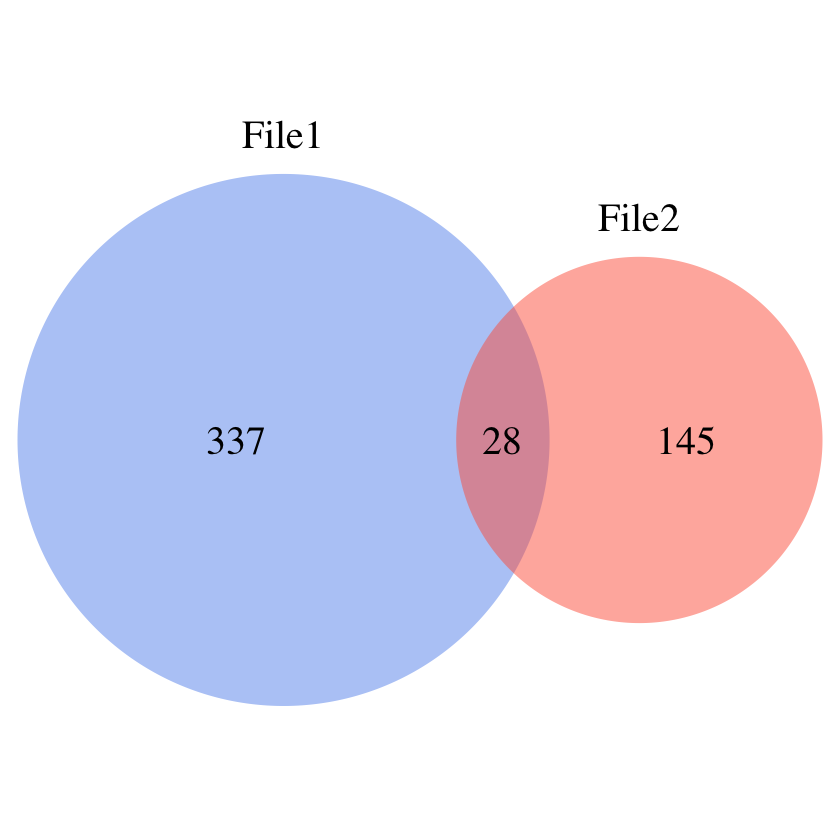

In [1]:
########################################################
# 1. Install/Load Required Package
########################################################
# If you haven't installed VennDiagram yet, uncomment:
# install.packages("VennDiagram")
library(VennDiagram)

########################################################
# 2. Read Gene Lists from CSV Files
########################################################
# Replace these with the actual paths to your CSV files
file1 <- "/Users/abdullahsaqib/Desktop/FYP_DATASETS/DEG_GSE45827.csv"
file2 <- "/Users/abdullahsaqib/Desktop/FYP_DATASETS/New_degs.csv"

# Since the first column of each CSV contains the gene names,
# we can directly select the first column using df[[1]].
df1 <- read.csv(file1, stringsAsFactors = FALSE)
df2 <- read.csv(file2, stringsAsFactors = FALSE)

genes1 <- df1[[1]]  # First column from file1
genes2 <- df2[[1]]  # First column from file2

########################################################
# 3. Create Sets and Identify Common Genes
########################################################
set1 <- unique(genes1)
set2 <- unique(genes2)

common_genes <- intersect(set1, set2)

# Print a summary of the counts
cat("Number of unique genes in File 1:", length(set1), "\n")
cat("Number of unique genes in File 2:", length(set2), "\n")
cat("Number of genes in common:", length(common_genes), "\n")

# List the common genes
cat("\nCommon Genes:\n")
print(common_genes)

# Optionally, write the common genes to a CSV file:
# write.csv(common_genes, file = "common_genes.csv", row.names = FALSE)

########################################################
# 4. Draw a Venn Diagram (with a fixed center intersection value of 28)
########################################################
venn.plot <- draw.pairwise.venn(
  area1      = length(set1),
  area2      = length(set2),
  cross.area = 28,  # Always display 28 in the intersection
  category   = c("File1", "File2"),
  fill       = c("cornflowerblue", "tomato"),
  lty        = "blank",     # line type for circles
  cex        = 2,           # text size inside the circles
  cat.cex    = 2,           # category label size
  cat.pos    = c(0, 0),     # position of category labels
  cat.dist   = 0.03         # distance of category labels from circles
)

# To view the diagram in an interactive session, simply run the code.
# To save the plot to a file, uncomment and adjust the following lines:
# png("venn_diagram.png", width = 800, height = 600)
# grid.draw(venn.plot)
# dev.off()


In [2]:
install.packages("VennDiagram")



The downloaded binary packages are in
	/var/folders/r4/8dcrm4qn38s6bjnvd17cg1t00000gn/T//RtmpZHIf2j/downloaded_packages
